Измалкова Дарья БКЛ182
# Домашнее задание № 2

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import f1
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from gensim.models import FastText
import ipdb
import spacy

## Подготовка данных

In [2]:
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])

In [3]:
negative['tone'] = negative['tone'].apply(lambda x: x * 0)
all_tweets_data = positive.append(negative)

In [4]:
def preprocess(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [5]:
all_tweets_data['clean_text'] = all_tweets_data.text.apply(preprocess)
all_tweets_data = shuffle(all_tweets_data[['clean_text','tone', 'text']])

In [6]:
train_data, val_data = train_test_split(all_tweets_data, test_size=0.2)

In [7]:
train_data[:10]

,clean_text,tone,text
80204,USER ну как такое может не дарить радость,1,@LudmilaMaslak ну как такое может не дарить ра...
88815,USER кстати где мой приз за лампочки и выключа...,1,@pavel_tychkov кстати где мой приз за лампочки...
3228,USER хз хотела у кого нибудь подготовиться,0,@OxanaStarostina хз( хотела у кого нибудь подг...
53148,на данный момент мои сладости это таблеточки ф...,0,на данный момент мои сладости - это таблеточки...
70296,USER а обещала написать gt lt попппаааа,0,@UmmiYosh а обещала написать &gt;.&lt; попппаааа(
108140,всем добра ага и тебе добра URL,1,Всем добра? — Ага и тебе добра) http://t.co/Ep...
81854,USER значит родители скорее всего назовут свое...,1,@hot_fact значит родители скорее всего назовут...
34556,q толстеешь ты зая a URL,0,"Q: Толстеешь ты, зая ( A: http://t.co/tigWKZx6QA"
19132,USER это она небось из женской солидарности ту...,0,@ninethin это она небось из женской солидарнос...
71439,USER даааа не позавидуешь ну хоть не помойка,1,@switeTutt даааа не позавидуешь... Ну хоть не ...


In [8]:
vocab = Counter()

for text in all_tweets_data['clean_text']:
    vocab.update(text.split())
print('Всего уникальных токенов:', len(vocab))

Всего уникальных токенов: 180374


In [9]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 1:
        filtered_vocab.add(word)
print('Уникальных слов, втретившихся больше 1 раза:', len(filtered_vocab))

Уникальных слов, втретившихся больше 1 раза: 77196


In [10]:
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

## Датасет

In [11]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

## Модель 1

In [13]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [14]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [15]:
fastt = FastText(all_tweets_data['clean_text'].tolist(), size=100, window=5, min_count=1)

In [16]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fastt.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0,0.1,100)

In [17]:
class CNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)

        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [18]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)  
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val metric: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [20]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [21]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7148247220936943
Train loss: 0.6976006860318391
Train loss: 0.6882218758647258
Train loss: 0.6808846271295341
Train loss: 0.6746522523890967

Evaluating on train...
Val loss: 0.6601677747333751, Val metric: 0.6401820182800293
Val loss: 0.6489690516306006, Val metric: 0.6317160725593567
Val loss: 0.6458167622868831, Val metric: 0.629989743232727
Val loss: 0.6438960390125247, Val metric: 0.6287928223609924
Val loss: 0.6426812290460214, Val metric: 0.628437340259552

Evaluating on test...
Val loss: 0.7245387807488441, Val metric: 0.6984189748764038
Val loss: 0.6790139499832603, Val metric: 0.6625226736068726
Val loss: 0.6667623290648828, Val metric: 0.6442864537239075
Val loss: 0.6610549824578421, Val metric: 0.6347607374191284
Val loss: 0.6571895371783864, Val metric: 0.6305662393569946

Epoch 1
Training...
Train loss: 0.6521405630251941
Train loss: 0.6371407508850098
Train loss: 0.6281039668963506
Train loss: 0.6208858502854546
Train loss: 0.6156787608546772

Evaluating on

In [22]:
def loss_graph(losses, val_losses):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.title('BCE loss value')
    plt.ylabel('BCE losses')
    plt.xlabel('epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def f1_graph(f1s, val_f1s):
    plt.plot(f1s)
    plt.plot(val_f1s)
    plt.title('f1 value')
    plt.ylabel('f1 value')
    plt.xlabel('epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

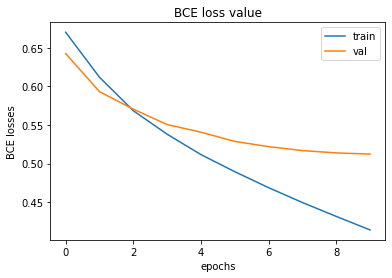

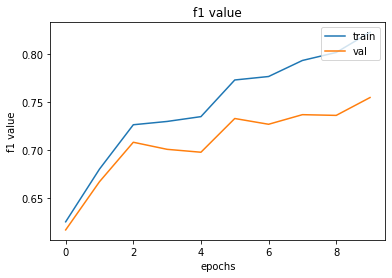

In [23]:
loss_graph(losses, val_losses)
f1_graph(f1s, val_f1s)

In [24]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [25]:
fp, fn, tp, tn = predict(model, val_iterator)

In [26]:
def metrics(tp, tn, fn):
    recall = len(tp)/(len(tp) + len(fn))
    precision = len(tp)/(len(tp) + len(fp))
    f_score = 2 * precision * recall / (precision + recall)
    print('precision: ', precision)
    print('recall: ', recall )
    print('f_score: ', f_score)

In [27]:
metrics(tp, tn, fn)

precision:  0.7425888495873336
recall:  0.768074912891986
f_score:  0.7551168964631325


In [28]:
print('fp :', len(fp))
print('fn :', len(fn))
print('tp :', len(tp))
print('tn :', len(tn))

fp : 6113
fn : 5325
tp : 17635
tn : 16294


In [29]:
fp[:10]

['спасибо насть ахахахахаха URL',
 'USER ненене не ладно мне будет жопа дома тем более страх перед тем что отберут ноутбук у меня еще есть',
 'rt USER завтра будет ужасный день но я надеюсь еще на хорошее',
 'rt USER 6789 гет я посвящаю USER USER USER USER USER USER счастья вам с lt з',
 'USER ага я так и прокомментировал про консультацию URL видимо у него не было сомнений в правоте печально',
 'rt USER бл неужели это сексуально даже не смотря аиу я бы пересрал URL',
 'rt USER USER ахахаха да',
 'rt USER лучше бы люди имели привычку уходить сразу и навсегда чем отдаляться и делать вид что все хорошо',
 'кать я бы очень хотел провести вечер и ночь также как и ты сейчас',
 'USER б лн думала пошляешся з мною десь до 1']

In [30]:
fn[:10]

['то чего я так старательно избегала но вроде получается не плохо work monday URL',
 'USER просто я отдыхаю и мне смешно на музик бокс',
 'наступает время для сна но не для меня URL',
 'rt USER USER я в деда мороза верю больше чем во все эти 11 11 11 и т д но каждый сходит с ума по своему',
 'шо то мне совсем не нрафки с буду пересматривать форсажик',
 'сегодня был тяжелый день и сейчас я с нетерпением жду сна',
 'USER надеюсь что ты не имеешь ввиду никого конкретно',
 'rt USER USER не кури не постареешь',
 'USER USER иос7 тоже кому то нравится а кому то нет',
 'USER я хотела так написать но мне пафоса не хватило']

Некоторые false positives как будто все-таки должны быть положительными - например, те в которых есть смех", какие-то окрашенные слова, видимо пропускает (например - "ужасный", "печально" ). 



С false negatives тоже некоторые, кажется, неверно помечены: "шо то мне совсем не нрафки с буду пересматривать форсажик". Некоторые, вообще, на мой взгляд, неоднозначные - последние два, например. 

---



## Модель 2

In [31]:
symb_vocab = Counter()

for text in all_tweets_data['clean_text']:
    for word in text:
      symb_vocab.update(list(word))

filtered_symb_vocab = set()

for word in symb_vocab:
    if symb_vocab[word] > 10:
        filtered_symb_vocab.add(word)

symbol2id = {'PAD':0}

for symbol in filtered_symb_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

### Датасет

In [32]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['clean_text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch):
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [33]:
train_dataset = WordSymbDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)


In [34]:
val_dataset = WordSymbDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

### Модель

In [35]:
class WordSymbCNN(nn.Module):

    def __init__(self, symb_vocab_size, embedding_dim, word_vocab_size):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, embedding_dim)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.symb_embedding = nn.Embedding(symb_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.word2hidden = nn.Linear(100, 10) 
        self.linear = nn.Linear(in_features=190, out_features=1)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()

    def forward(self, words, symbs):

        emb_symbs = self.symb_embedding(symbs).transpose(1,2)
        emb_words = self.word_embedding(words)  
        mean_emb_words = torch.mean(emb_words, dim=1)
        
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(emb_symbs)))
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(emb_symbs)))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        
        concat = torch.cat((pooling1, pooling2), 1)

        vec = self.word2hidden(mean_emb_words)

        concat = torch.cat((concat, vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [36]:
def train2(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (words, symbs, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        preds = model(words, symbs)
        loss = criterion(preds, ys) 
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [37]:
def evaluate2(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbs, ys) in enumerate(iterator):   
            preds = model(words, symbs)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val metric: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [38]:
model = WordSymbCNN(len(symbol2id), 100, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [39]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(5):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train2(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate2(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate2(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.6694027921732735
Train loss: 0.6273615109747734
Train loss: 0.6056324197695806
Train loss: 0.5924317699542149
Train loss: 0.5823892063793095

Evaluating on train...
Val loss: 0.5494102467508877, Val metric: 0.722758412361145
Val loss: 0.5425648637439894, Val metric: 0.7118628025054932
Val loss: 0.5399346517828795, Val metric: 0.7082595825195312
Val loss: 0.5383773321728055, Val metric: 0.7066978216171265
Val loss: 0.5371490638146456, Val metric: 0.7059562802314758

Evaluating on test...
Val loss: 0.6055614277720451, Val metric: 0.7888311147689819
Val loss: 0.5669638619703405, Val metric: 0.7480679750442505
Val loss: 0.5565053453812232, Val metric: 0.7313622832298279
Val loss: 0.5499317816325596, Val metric: 0.7237275242805481
Val loss: 0.5476777716116472, Val metric: 0.71879643201828

Epoch 1
Training...
Train loss: 0.5475319150616141
Train loss: 0.5390170579371245
Train loss: 0.5314344012966523
Train loss: 0.5264623392400124
Train loss: 0.52219721709

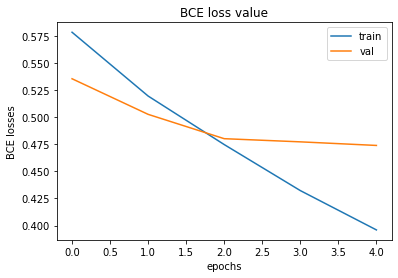

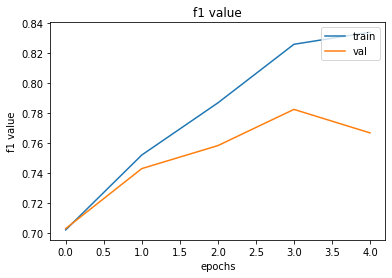

In [40]:
loss_graph(losses, val_losses)
f1_graph(f1s, val_f1s)

In [41]:
def predict_2(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (words, symbs, ys) in enumerate(iterator):  
            preds = model(words, symbs)  
            for pred, gold, text in zip(preds, ys, words):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [42]:
fp, fn, tp, tn = predict_2(model, val_iterator)

In [43]:
print('fp :', len(fp))
print('fn :', len(fn))
print('tp :', len(tp))
print('tn :', len(tn))

fp : 4210
fn : 6041
tp : 16919
tn : 18197


In [44]:
metrics(tp, tn, fn)

precision:  0.8007477874012021
recall:  0.7368902439024391
f_score:  0.7674930254712059


In [45]:
fp[:10]

['спасибо насть ахахахахаха URL',
 'USER ненене не ладно мне будет жопа дома тем более страх перед тем что отберут ноутбук у меня еще есть',
 'rt USER 6789 гет я посвящаю USER USER USER USER USER USER счастья вам с lt з',
 'никто не хочет кататься на коньках сама решила что лучше кататься на ватрушке и дима сверху',
 'rt USER USER ахахаха да',
 'rt USER лучше бы люди имели привычку уходить сразу и навсегда чем отдаляться и делать вид что все хорошо',
 'USER пардон все пропустила кажется и хто у нас дама',
 'кать я бы очень хотел провести вечер и ночь также как и ты сейчас',
 'USER б лн думала пошляешся з мною десь до 1',
 'USER вот всегда здесь так в самый интересный момент произносится фраза это не для твиттера']

In [46]:
fn[:10]

['USER на одного друга теперь больше да мне везет сегодня я кстати ян но это не мое имя просто оно безобидное',
 'несмотря на пробки мы все равно попали на экскурсии все по плану',
 'то чего я так старательно избегала но вроде получается не плохо work monday URL',
 'USER хотелось бы так думать а это у тебя на нач сектора аттестация',
 'наступает время для сна но не для меня URL',
 'rt USER USER я в деда мороза верю больше чем во все эти 11 11 11 и т д но каждый сходит с ума по своему',
 'шо то мне совсем не нрафки с буду пересматривать форсажик',
 'сегодня был тяжелый день и сейчас я с нетерпением жду сна',
 'USER почему рассказать о своих делах сразу жаловаться все хорошо с',
 'rt USER USER не кури не постареешь']

Модель с двумя входами, кажется, немного лучше

## Улучшенная модель 1
Оставим в тексте пунктуацию, превратим последовательности скобок в смайлы и добавим дропаут

In [74]:
def lighter_preprocess(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('(\)+?)',' :)', text)
    text = re.sub('(\(+?)',' :(', text)
    return text

In [75]:
all_tweets_data['clean_text'] = all_tweets_data['text'].apply(lighter_preprocess)

In [76]:
train_data, val_data = train_test_split(all_tweets_data, test_size=0.2)

In [77]:
vocab = Counter()
for text in all_tweets_data['clean_text']:
    vocab.update(text.split())
for word in vocab:
    if vocab[word] > 1:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    
id2word = {i:word for word, i in word2id.items()}

In [51]:
class BetterCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)

        logits = self.dropout(self.hidden(concat)) 
        logits = self.out(logits)      
        return logits

In [79]:
train_dataset = TweetsDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [81]:
val_dataset = TweetsDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [82]:
model = BetterCNN(len(word2id), 10)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [83]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(5):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.6867709948736078
Train loss: 0.5957889712375143
Train loss: 0.550315826271589
Train loss: 0.5202435939003238
Train loss: 0.499893334747731

Evaluating on train...
Val loss: 0.27196017871884737, Val metric: 0.9784131646156311
Val loss: 0.26778250803118164, Val metric: 0.9638700485229492
Val loss: 0.26636611584287423, Val metric: 0.9595323801040649
Val loss: 0.2655200973260317, Val metric: 0.957162082195282
Val loss: 0.2653056297494077, Val metric: 0.9556171894073486

Evaluating on test...
Val loss: 0.2931947074830532, Val metric: 1.0736322402954102
Val loss: 0.2777574623332304, Val metric: 1.009211778640747
Val loss: 0.27188147948338437, Val metric: 0.9892954230308533
Val loss: 0.2702282113688333, Val metric: 0.9789024591445923
Val loss: 0.26836882599375467, Val metric: 0.9734342694282532

Epoch 1
Training...
Train loss: 0.4198850778972401
Train loss: 0.408334840035093
Train loss: 0.4037459690410357
Train loss: 0.40025744828388843
Train loss: 0.3971419

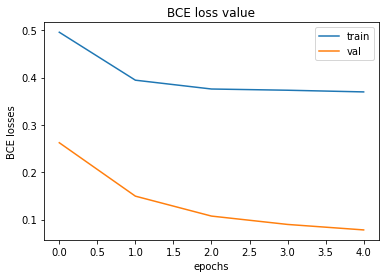

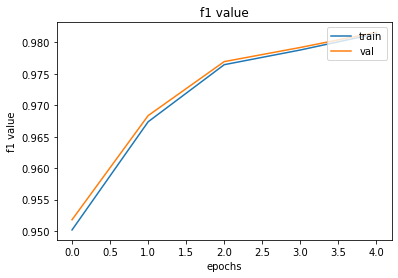

In [84]:
loss_graph(losses, val_losses)
f1_graph(f1s, val_f1s)

In [85]:
fp, fn, tp, tn = predict(model, val_iterator)

In [86]:
metrics(tp, tn, fn)

precision:  0.9704498240556239
recall:  0.9927570802793078
f_score:  0.9814767172626705


In [87]:
print('fp :', len(fp))
print('fn :', len(fn))
print('tp :', len(tp))
print('tn :', len(tn))

fp : 697
fn : 167
tp : 22890
tn : 21613


In [88]:
fp[:10]

['USER сайн уу, хүүхдүүд сайн уу',
 'rt USER я ржал как мудак когда смотрел первый раз URL',
 'так плохо было с завтра не дадут в тот раз: :(если что ире хоть одной в больнице не скучно будет ахах',
 'никаких планов на новый год,вообще ничего не',
 'посадили с бля от него воняет',
 'USER USER USER я не знаю почему мне так URL',
 'rt USER ассоциация с юном USER URL',
 'USER да и люди там представляют нашу вселенную',
 '"где бы ни работать, лишь бы не работать" : :(// URL',
 'вот это у меня сейчас был приступ боли аж заревела: в мире существуют таблетки']

In [89]:
fn[:10]

['USER красава , поздравляю :* я знала , что у тебя все получится!',
 'USER ихих эй чувак отлично проведи эту ночь:*',
 'rt USER #хочупровестиновогоднююночьвместес USER USER USER USER USER USER было бы',
 'меня ян пометил :)0 :)0 :)0 USER URL',
 'rt USER "в было удобнее играть с мне вязала варежки с отдельным указательным пальцем"',
 'USER да хорошо там и встретимся!',
 'USER можно желание загадывать с 11 и до 14 минут его загадывать :)вот и попадешь в точку',
 'rt USER USER а у тебя? что',
 'USER ты во-первых, нахрена тебе худеть, во-вторых зачем худеть так?!',
 'USER USER']

Модель работает значительно лучше, полагаю, это прежде всего из-за  наличия смайликов. Некоторые ошибки, кажется, на самом деле ошибки разметки, хотя есть и честные ошибки, которые непонятно откуда взялись (твиты в фп с явно окрашенными словами - "плохо", "заревела", в фн - "красава", "хорошо" ) Возможно, помогла бы лемматизация? - всякие "плакать", "реветь" и производные было бы легче выделить.

## Улучшенная модель 2


In [100]:

symb_vocab = Counter()

for text in all_tweets_data['clean_text']:
    for word in text:
      symb_vocab.update(list(word))

filtered_symb_vocab = set()

for symbol in symb_vocab:
    if symb_vocab[symbol] > 5:
        filtered_symb_vocab.add(symbol)

symbol2id = {'PAD':0}

for symbol in filtered_symb_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [101]:
class BetterWordSymbCNN(nn.Module):

    def __init__(self, symb_vocab_size, embedding_dim, word_vocab_size):
        super().__init__()

        self.word_embedding = nn.Embedding(word_vocab_size, embedding_dim)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.symb_embedding = nn.Embedding(symb_vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.word2hidden = nn.Linear(100, 10) 
        self.linear = nn.Linear(in_features=190, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()

    def forward(self, words, symbs):

        emb_symbs = self.symb_embedding(symbs).transpose(1,2)
        emb_words = self.word_embedding(words)  
        mean_emb_words = torch.mean(emb_words, dim=1)
        
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(emb_symbs))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(emb_symbs))))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        
        concat = torch.cat((pooling1, pooling2), 1)

        vec = self.dropout(self.word2hidden(mean_emb_words))

        concat = torch.cat((concat, vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [102]:
train_dataset = WordSymbDataset(train_data, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)


In [103]:
val_dataset = WordSymbDataset(val_data, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [104]:
model = BetterWordSymbCNN(len(symbol2id), 100, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [105]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(2):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train2(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate2(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate2(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.34116602973902926
Train loss: 0.19829462430831316
Train loss: 0.14203536798819327
Train loss: 0.11119019453206079
Train loss: 0.09153182285666552

Evaluating on train...
Val loss: 0.013347569086095867, Val metric: 1.0261262655258179
Val loss: 0.013036564842838308, Val metric: 1.0113070011138916
Val loss: 0.012614792678505182, Val metric: 1.0066808462142944
Val loss: 0.012615825572191812, Val metric: 1.0042476654052734
Val loss: 0.01268351970818536, Val metric: 1.0027964115142822

Evaluating on test...
Val loss: 0.013466230826452374, Val metric: 1.1216354370117188
Val loss: 0.013082051868824399, Val metric: 1.0556704998016357
Val loss: 0.013228716042179327, Val metric: 1.035471796989441
Val loss: 0.013147911509232862, Val metric: 1.0256670713424683
Val loss: 0.012527826951224019, Val metric: 1.019984245300293

Epoch 1
Training...
Train loss: 0.010205681791857761
Train loss: 0.008645346027164571
Train loss: 0.007914712354809476
Train loss: 0.00734591943

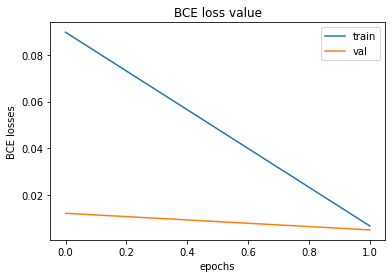

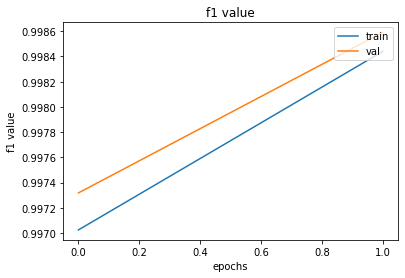

In [106]:
loss_graph(losses, val_losses)
f1_graph(f1s, val_f1s)

In [107]:
fp, fn, tp, tn = predict_2(model, val_iterator)

In [108]:
metrics(tp, tn, fn)

precision:  0.9976622364604528
recall:  0.9994795506787526
f_score:  0.9985700667302192


In [109]:
print('fp :', len(fp))
print('fn :', len(fn))
print('tp :', len(tp))
print('tn :', len(tn))

fp : 54
fn : 12
tp : 23045
tn : 22256


In [110]:
fp[:10]

['USER красота *-* эх, приходится довольствоваться простыми елками',
 'rt USER 3к твит для USER USER USER c:',
 'USER го ты в 14:00 подойдешь в пойдем куда ж много гулять жи скор',
 'USER неа. из за папы я всегда буду чувствовать что я в этой жизни ничего не добился',
 'rt USER #дирекшионерфолловьдирекшионера #взаимныйфолловинг #читаювзаимно осталось 146 с::',
 'rt USER омо *_* URL',
 'rt USER USER ааа,ну это да:с + с тем что юрец всегда позже начинается реально напряжно',
 'USER я не картон режу и поэтому гоу хd',
 'rt USER #happybirthdayjaredleto люблю этот фильм *о* URL',
 'rt USER лу для USER с: добра тебе URL']

In [111]:
fn

['"USER ну и URL',
 'майдан онлайн трансляция URL с помощью USER',
 'rt USER ну так как-то подписывайся на инстаграм USER #важенкаждый URL',
 '"USER USER ваалейкум ва ва URL',
 '"USER я тоже вас люблю! URL',
 'любимая тема USER URL',
 'USER во вчерашней речь шла о букве',
 'понимает меня,как никто другой только - USER URL',
 'USER бля. да хули в ней русского. вот в джерси как собирают URL ненавижу блядь кислоту с которой не прет',
 'смеемся как упоротые и слушаем любимые треки с USER',
 'так круто было увидеться наконец с эдичкой USER',
 'посмотри кто у тебя первый в списке друзей? увидел? человечек тебе дорог. не вздумай проебать его. у меня первая USER']

Здесь тоже, значительно лучше. Некоторые ошибки, кажется, из-за разметки. Некоторые твиты, на мой взгляд, неоднозначны - "USER го ты в 14:00 подойдешь в пойдем куда ж много гулять жи скор". Возможно, некоторые фп - это сарказм, но я даже не представляю как его можно распознать))

